## Imports

In [1]:
library(mvtnorm)
library(scar)
library(R.matlab)
library(reshape2)
library(progress)
set.seed(18)
options(warn=-1) 

R.matlab v3.6.2 (2018-09-26) successfully loaded. See ?R.matlab for help.

Attaching package: ‘R.matlab’

The following objects are masked from ‘package:base’:

    getOption, isOpen



## Data Processing

In [27]:
# Read data
# source = readMat("mine_data.mat")
source = readMat("mine_sim_log.mat")
df = source$data

In [30]:
head(df)

x,y,X1,X2,X3,X4,X5,X6,X7,X8,...,X3991,X3992,X3993,X3994,X3995,X3996,X3997,X3998,X3999,X4000
4,15,98.80575,98.87496,98.54934,98.76435,99.35411,98.95824,99.49197,99.40185,...,662.0814,662.5103,662.3005,664.7158,662.9293,660.8996,660.4560,658.5569,661.2726,663.2150
4,21,99.40213,99.04992,97.78084,97.57213,97.69511,97.80081,99.46071,98.85886,...,662.2872,661.9081,662.7219,663.3495,663.8755,660.4766,660.1395,659.5363,662.4105,666.7248
4,27,99.69802,98.89906,98.37084,98.73756,98.55004,99.24728,98.31017,99.14444,...,663.8917,663.0482,661.6808,664.4375,665.5411,660.8334,660.4354,658.1685,662.8256,666.4437
7,12,98.42299,98.77900,98.14147,97.89115,98.95303,99.30685,98.86317,98.90929,...,663.6416,662.9346,660.0267,664.2487,664.9224,659.7522,659.6738,660.3475,660.0020,665.3496
7,17,99.62950,97.74232,97.99953,98.69109,98.41880,99.63575,99.48986,99.23098,...,662.7045,662.4563,661.7100,665.4837,664.7541,661.7450,662.0066,659.3269,661.0653,666.4766
7,18,97.27448,98.51608,96.93830,98.19335,98.00933,99.16169,99.60174,99.35162,...,660.8487,663.9059,661.4876,666.7038,662.5975,661.7801,659.5383,659.9236,660.6111,666.5096


In [29]:
# Remove col 1,4,5
colnames(df) = c("x","y",paste("X",1:(ncol(df)-2),sep=""))

In [43]:
# Generate sample
generate.sample = function(df, sample_size=30){
    
    # Sample locations
    s = sample(1:nrow(df), sample_size, replace=FALSE) 
    subset = df[s,]
    
    # Construct data
    data = matrix(NA, 1, ncol(df)) 
    for (i in 1:sample_size) {
        row = subset - rep(subset[i,], each=sample_size)
        data = rbind(data, row)
    }
    
    # Convert to data frame object
    data = as.data.frame(data[-1,])
    
    data$d = sqrt(data[,"x"]^2 + data[,"y"]^2)

    return(data[,-c(1,2)])

}

In [44]:
# Generate data
sample_set = generate.sample(df)

## Estimating `f`
Package [scar](https://cran.r-project.org/web/packages/scar/scar.pdf)
* `l`: linear
* `in`: monotonically increasing
* `de`: monotonically decreasing
* `cvx`: convex
* `cvxin`: convex and increasing
* `cvxde`: convex and decreasing
* `ccv`: concave
* `ccvin`: concave and increasing
* `ccvde`: concave and decreasing

In [47]:
# basis function
g = function(x, type="i", degree=NULL){
    
    if (type=="i"){ # identity
        return(x)
        
    } else if (type=="p"){ # polynomial
        if (is.null(degree)){degree=2}
        return(x^degree)
        
    } else if (type=="e"){ # exponential
        return(exp(x))
    
    } else if (type=="ln"){ # logarithm
        return(log(x))
    }
}

In [5]:
# Calculate weight matrix
to.weight = function(x, object, n){
    y = predict(object, x)
    m = matrix(y, nrow=n, ncol=n)
    W = 1 - m/rowSums(m)
    return(W)
    
}

In [48]:
# train
run = function(x, y, n, shape=c('in'), type='i', degree=NULL){
    
    if (!is.matrix(x)) {
        x = matrix(x, ncol=1)
    }
    
    # transform x,y
    y = abs(y)
    x = g(x, type=type, degree=degree)
    
    # estimate f
    object = scar(x, y, shape=shape, family=gaussian())
    pred_y = predict(object, x)
    
    return(pred_y)
}

In [49]:
head(sample_set,3)

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X3992,X3993,X3994,X3995,X3996,X3997,X3998,X3999,X4000,d
0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000000,0.0000000,0.0000000,0.00000000,...,0.00000000,0.00000000,0.000000,0.000000,0.000000,0.00000000,0.000000,0.000000,0.0000000,0.0000
-0.7140576,-0.3111117,0.7855104,0.3073676,-1.8649136,-0.1738240,0.0006338106,1.0905449,0.1443150,0.08216645,...,-0.06974514,0.04103607,1.965950,3.226052,-2.349709,0.08740364,1.040092,1.511039,2.7999602,48.0000
-0.1141886,-0.4743686,-0.6543425,-0.4138670,0.6423331,-0.9050698,0.2297441856,-0.2193274,-0.1396733,-0.65976430,...,-0.39546965,0.13575025,1.362601,3.777716,-1.231060,1.68350889,1.887143,-0.609885,-0.3127709,114.2804


In [ ]:
results = list()
for (t in 1:4000){
    y = run(sample_set$d, sample_set[, t], shape=c('ccvin'))
    results[[t]] = y
    
}



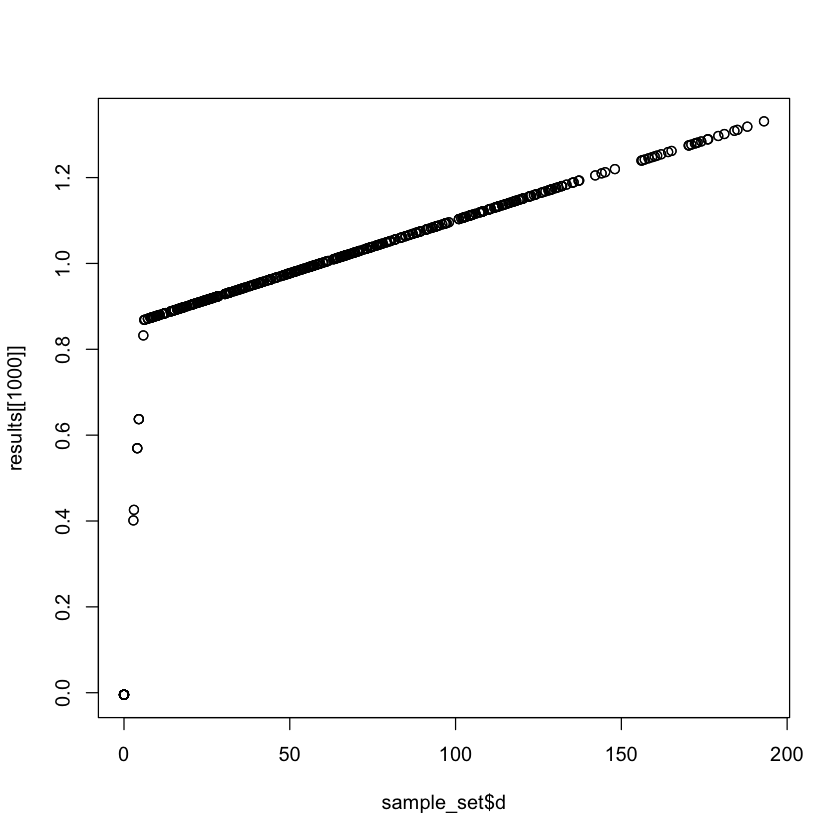

In [95]:
plot(sample_set$d, results[[1000]])

In [88]:
out = data.frame(matrix(unlist(results), nrow=900, ncol=4000))

In [90]:
write.csv(out, 'r_estimates_sim.csv')

# Simulation

In [ ]:
library(R.matlab)

In [2]:
# download landslide data
mine = readMat('mine_data.mat')
mine = mine$data

In [3]:
head(mine)

4,15,0.08358232,0.01395277,0.2307818,0.5402930,0.293333620,-0.06579680,-0.11955777,-0.25955072,...,-3.9134459,-3.6763182,-3.6409020,-3.8099766,-3.8599601,-3.7017708,-3.8246517,-3.5830660,-4.15982389,-3.6389778
4,21,0.43382502,0.42173687,0.5965990,0.8655204,0.573409617,0.35516313,0.62281382,0.26462597,...,-0.6163901,-0.7752501,-0.3271922,-0.5319402,-0.8885893,-0.5359016,-0.5153001,-0.2794443,-0.08752578,0.1018024
4,27,0.08931409,-0.17760377,0.2552893,0.4079655,0.006454904,0.14898869,0.19247806,-0.55295944,...,-4.6415410,-4.4743199,-4.6982594,-4.8074012,-4.9714327,-4.5411687,-4.4685721,-4.4123754,-4.68760824,-4.6057286
7,12,-0.01746205,-0.26998803,0.2531567,0.4788606,0.102463819,-0.10589835,-0.03311277,-0.17097090,...,87.1857986,87.4798203,87.3908539,87.1582031,87.2125397,87.3416596,87.4029999,87.5099945,87.03620148,87.6109161
7,17,0.18281053,0.07100489,0.4083487,0.5861681,0.401928693,0.02840278,0.08266623,-0.02217194,...,136.0935211,136.3583679,136.3204803,136.2729645,136.3047791,136.3992004,136.4444580,136.5916443,136.28152466,136.7804260
7,18,0.15503900,0.02543500,0.3168480,0.4215370,0.241781000,-0.21098000,-0.17835000,-0.37378000,...,2.8990840,3.1155300,3.0181410,3.0078160,2.9781180,3.0419640,3.0262350,3.1632330,2.83196700,3.2499960


In [4]:
# simulate geometric brownian motion 
mu = 0.5
n =4000
dt = 0.001
x0 = 100
sigma_ =  0.1

exp.t = matrix(0,ncol = n)
for (i in 1:n){
  exp.t[1,i] = exp((mu - sigma_^2/2)*dt + sigma_ * rnorm(1,0,sqrt(dt)))
}
exp.t = x0*cumprod(exp.t)

In [ ]:
plot(exp.t, xlab = "time", ylab = "displacement")

In [ ]:
alpha = seq(0.01,1,length.out = 4000)
plot(alpha[100]*log(1:200))))

In [7]:
mine_sim = matrix(NA, 1803, 4000)

In [6]:
find_distance = function(data,i,j){
  return(sqrt((data[i,1] - data[j,1])^2+(data[i,2]- data[j,2])^2))
    }

In [10]:
# generate synthesised data
for(t in 1:4000){
  for(i in 1:1803){
    if(i == 839){
      mine_sim[i,t] = exp.t[t]
    }
    else{
      mine_sim[i,t] = exp.t[t] - abs(rnorm(1,alpha[t]*log(find_distance(mine[,1:2],i,839)),1))
    }
  }
}


In [ ]:
mine_sim[,1:2]

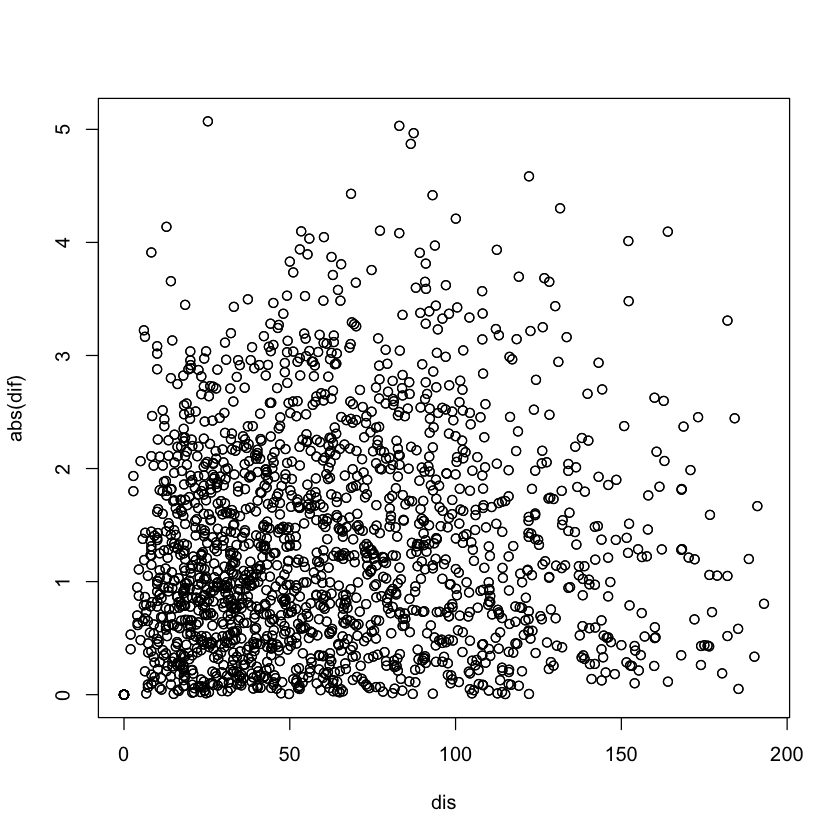

In [16]:
# select 30 locations and make graphs about distance vs diff of observation
index = seq(1,1803,by=30)
index = sample(1:1803,60,replace = FALSE)
dis = c()
dif = c()

for(i in 1:length(index)){
  for(j in 1:length(index)){
    dis = cbind(dis,find_distance(mine_sim[,1:2],index[i],index[j]))
    dif = cbind(dif,mine_sim[index[i],3000]-mine_sim[index[j],3000])
  }
}
plot(dis,abs(dif))

In [13]:
head(mine_sim)
dim(mine_sim)

4,15,98.80575,98.87496,98.54934,98.76435,99.35411,98.95824,99.49197,99.40185,...,662.0814,662.5103,662.3005,664.7158,662.9293,660.8996,660.4560,658.5569,661.2726,663.2150
4,21,99.40213,99.04992,97.78084,97.57213,97.69511,97.80081,99.46071,98.85886,...,662.2872,661.9081,662.7219,663.3495,663.8755,660.4766,660.1395,659.5363,662.4105,666.7248
4,27,99.69802,98.89906,98.37084,98.73756,98.55004,99.24728,98.31017,99.14444,...,663.8917,663.0482,661.6808,664.4375,665.5411,660.8334,660.4354,658.1685,662.8256,666.4437
7,12,98.42299,98.77900,98.14147,97.89115,98.95303,99.30685,98.86317,98.90929,...,663.6416,662.9346,660.0267,664.2487,664.9224,659.7522,659.6738,660.3475,660.0020,665.3496
7,17,99.62950,97.74232,97.99953,98.69109,98.41880,99.63575,99.48986,99.23098,...,662.7045,662.4563,661.7100,665.4837,664.7541,661.7450,662.0066,659.3269,661.0653,666.4766
7,18,97.27448,98.51608,96.93830,98.19335,98.00933,99.16169,99.60174,99.35162,...,660.8487,663.9059,661.4876,666.7038,662.5975,661.7801,659.5383,659.9236,660.6111,666.5096


[1] 1803 4002

In [12]:
mine_sim = cbind(mine[,1:2], mine_sim)

In [14]:
writeMat("mine_sim_log.mat", data = mine_sim)

In [2]:
mine_sim = readMat('mine_sim.mat')
mine_sim = mine_sim$data

In [3]:
head(mine_sim)

4,15,97.35295,99.50298,97.64096,98.26076,96.89963,97.73230,97.48803,99.33348,...,618.8205,613.2667,615.2093,611.7603,609.5837,613.7745,615.4628,609.9048,609.1903,610.1859
4,21,99.65431,98.02352,98.23350,98.86441,98.91674,98.41779,98.51346,98.17659,...,617.4276,615.3878,615.5118,613.2317,610.7172,615.0628,615.6389,610.3637,611.2576,609.7269
4,27,98.73648,98.66940,96.78872,98.17011,98.28664,99.35064,97.23291,97.58186,...,617.9576,613.1390,613.4673,611.0345,608.6619,614.9957,613.7094,607.4697,607.4373,607.1449
7,12,99.42742,98.95165,98.39259,98.49089,99.47900,98.56305,98.42115,98.81878,...,634.6091,630.7280,629.2688,629.7771,625.3203,630.2031,630.8494,626.5891,626.1280,625.8942
7,17,99.79434,99.56241,97.07623,98.19955,97.48291,98.24006,96.94739,99.27628,...,635.9462,631.2319,630.8831,629.4860,627.6490,631.6319,632.0473,627.1784,626.9695,626.3505
7,18,99.29523,99.92853,99.01489,99.39517,98.55209,99.06962,98.39598,99.88313,...,637.0351,631.7243,634.1195,629.5982,627.6137,634.0788,632.6722,626.4554,626.2425,626.8679
